# Inputs to bolo-calc
This notebook documents where we got the various numbers that are used as inputs to bolo-calc for runs in this directory.

## Optics:  Dielectric losses

Loss tangents:
- Alumina:  
    - Using 3E-4 
    - 3E-4 (+- 1E-4) is value at 77K, from SPT3g, Nadolski etal, https://arxiv.org/abs/1912.04272 table 1.
- Silicon:  
    - Using Czochralski process silicon, which has some impurities.
    - Using 5.0E-5
    - Dutta etal, https://arxiv.org/pdf/1307.4715.pdf , gives an upper limit of 8e-5 at and below 30K for the worse sample.  So, 8e-5 would be very very conservative;  5e-5 is probably conservative.
 
- HDPE:  
    - At ~4K (lenses), Using 0.8E-4, but I don't know the source of this.
    - At ~300K (the window, really UHMWPE), we have been using 2E-4, which is the number Brad Benson uses (citing Lamb) for SPT3g.  However, Lamb does not have specific entries for UHMWPE.  His numbers for HDPE range from 2.1 to 3.9 in our frequency range, so I am going to change this to 3E-4 for the window.

<BR>

Nylon loss:
- Halpern, Gush, Wishnow and de Cosmo, https://www.osapublishing.org/ao/abstract.cfm?uri=ao-25-4-565
- They fit absorption to a model with $ T \propto e^{-\alpha z}$, with $\alpha = a \nu^b$.
    
- They find alpha goes as $\nu^{2.9}$ rather than the $\nu^1$ expected for a loss tangent model.   A footnote in their paper says their $a$ and $b$ for nylon are not precise, but should only be used as "guides".
    
- The Spider group did a run with a 1" thick nylon filter (rather than the usual 3/32") and found the 280GHz in-band optical efficiency went down by a factor of about 2/3.  Using the $a$ from Halpern etal and adjusting $b$ to agree with this measurement gives $b = 2.6$.  (We could have adjusted $a$ instead, or both).  We proceed with this value of $b$, understanding that this is not a great constraint and needs better data.  

<BR>
        
RTMLI loss:
- This is a scatterer.  It is not obvious how it should scale with photon frequency, and there's very little data on "in-band" performance.  Bicep3 (https://arxiv.org/abs/1808.00567) does have an estimate of the loading (at 90GHz) from their RTMLI filters, though how it was arrived at is not well-described.  Below we make a model that matches their loading at 90GHz, and scales from there as $\alpha \propto \nu^b$, where the index of that power law ($b$) is derived by a fit to the original RTMLI paper's transmission spectra.
    
- Our model for this scattering filter is that it dumps the scattered power to the same temperature as the filter.  This is probably a bad assumption when the filter is very tranmissive, as it is in-band.  For our geometry, I think it is more likely the scattering goes to areas skyward of the filter.  For the SATs a lot of this would be on the ambient-temperature baffle (and some on the sky), and on the LATs it would be divided between the cabin and the sky.  
    - For the SATs (or Bicep3) the power would then fall partly at ~250K and partly at ~15K, so our model of filter temperature ~140K (see below) is not terrible, in that it not terribly far from the average of the baffle and sky.  This suggests that our use of Bicep3 below to normalize the zotefoam scattering is not subject to enormous changes from this effect.
    - For SPT3g (another comparision point that I don't understand the constraints from yet), much of the window scattering will go to ~280K, and some to the cold sky.  
    - For the LATs, we know from sidelobe studies that wide angle (eg Lambertian) scattering goes mostly to the cabin walls.  Much of that gets to the sky if those walls are not very absorbing.  So, in that case the foam scattering gets divided between the ambient temperature walls (10-20%) and the cold sky.  In that case the Zotefoam loading would be lower than we calculate here.

## Nylon filter 
Currently used only the SATs.
Specified in PBDR as 7.5mm thick for all bands.


In [348]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 8]

sat_nus =   np.array([      25.75, 38.75, 85.0, 95.0, 145.0, 155.0, 227.0, 285.5])
#splat_nus = np.array([20.0, 25.75, 38.75, 91.5, 148.5,              227.0, 285.5])
#chlat_nus = np.array([      25.75, 38.75, 91.5, 148.5,              227.0, 285.5])

telescopes =['SAT'] #,'splat','chlat']
nu_dict = {'SAT':sat_nus, 'SPLAT':splat_nus, 'CHLAT':chlat_nus}

# From Halpern etal
a_nylon = 5e-4
b_nylon = 2.6   # Halpern says 2.9, we renormalize to Spider and get 2.6.
delta_z = 0.75 #cm
#delta_z = 2.30 #cm  (Use to check Spider 0.33 abs at 280GHz)

for tel in telescopes:
    print(tel)

    for nu in nu_dict[tel]:
        icm = nu/30.
        alpha_nylon = a_nylon*icm**b_nylon     # units are cm^-1
        transmission_nylon = np.exp(-alpha_nylon*delta_z)
        abs_nylon = 1-transmission_nylon  
        print('nu = {0:5.1f} GHz, icm={1:4.2f}, alpha={2:4.3f}, Abs = {3:7.4f}'.format(nu, icm, alpha_nylon, abs_nylon))

SAT
nu =  25.8 GHz, icm=0.86, alpha=0.000, Abs =  0.0003
nu =  38.8 GHz, icm=1.29, alpha=0.001, Abs =  0.0007
nu =  85.0 GHz, icm=2.83, alpha=0.007, Abs =  0.0056
nu =  95.0 GHz, icm=3.17, alpha=0.010, Abs =  0.0075
nu = 145.0 GHz, icm=4.83, alpha=0.030, Abs =  0.0223
nu = 155.0 GHz, icm=5.17, alpha=0.036, Abs =  0.0265
nu = 227.0 GHz, icm=7.57, alpha=0.096, Abs =  0.0698
nu = 285.5 GHz, icm=9.52, alpha=0.175, Abs =  0.1230


# RTMLI
CMB-S4 plans to use a Bicep3-like stack of thin foam filters, aka "RTMLI", to reduce infrared loading on the cryogenic stages.  In Bicep3 (and in SPT3g) the stack is:

- 10 layers, each 1/8" thick, spaced 1/8" apart.
- Made of Zotefoam HD30

We need to find a reasonable model of the frequency-dependence of this filter stack.  Below, I try to build a Halpern-like model:

$$\alpha = b \nu^a $$ 
$$T = e^{-\alpha*n_{layers}}$$
using three data inputs:
- The original RTMLI paper, which has frequency-dependent transmission curves that can be used to extract $b$ for that foam, 
- The Bicep3 loading estimate (at 90GHz) from their RTMLI filters, which can be used to extract $a$ (given $b$) for HD30, and
- unpublished transmission spectra of HD30 from Lorenzo Moncelsi from 220 to 280GHz.

### Original RTMLI paper - find "b"
I used a web app to grab some data points from 

REVIEW OF SCIENTIFIC INSTRUMENTS 84, 114502 (2013) <BR>
Radio-transparent multi-layer insulation for radiowave receivers <BR>
J. Choi,H. Ishitsuka,S. Mima,S. Oguri, K. Takahashi,and O. Tajima
    
This paper uses:
- Styroace-II Styrofoam, from Dow Chemical Company.
- Each layer is 3mm thick, which I'm going to say is equivalent to the 1/8" of the HD30 layers used by SPT3g and Bicep.  From hereon, we'll talk about loss or absorption per layer, rather than per cm.
    
This is not the same foam as used by Bicep or SPT3g, but it is the only source I'm aware of of good frequency dependent transmission up to a region where transmission drops significantly.  We'll use these data to find a plausible frequency power law scaling exponent ($b$) for RTMLI.

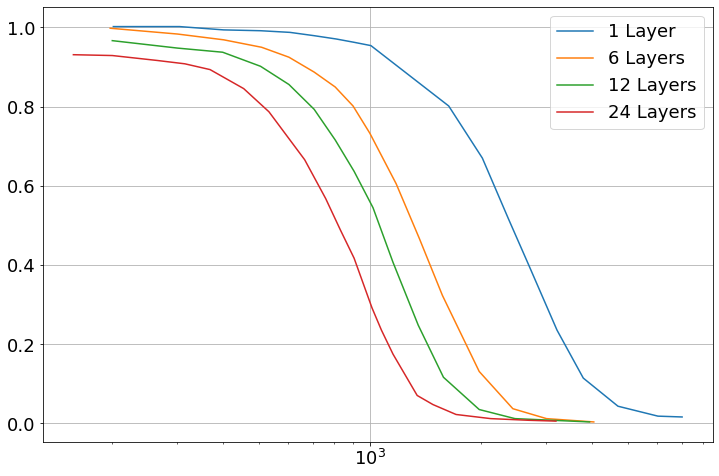

In [225]:
# Read in the data I screen-grabbed from Choi etal
nu1,rtmli_1 = np.loadtxt('rtmli_1.txt',unpack=True,delimiter=', ')
nu2,rtmli_2 = np.loadtxt('rtmli_2.txt',unpack=True,delimiter=', ')
nu3,rtmli_3 = np.loadtxt('rtmli_3.txt',unpack=True,delimiter=', ')
nu4,rtmli_4 = np.loadtxt('rtmli_4.txt',unpack=True,delimiter=', ')

# Plot it to make sure it makes sense.
plt.semilogx(nu1,rtmli_1,label='1 Layer')
plt.semilogx(nu2,rtmli_2,label='6 Layers')
plt.semilogx(nu3,rtmli_3,label='12 Layers')
plt.semilogx(nu4,rtmli_4,label='24 Layers')
plt.legend()
plt.grid()

1 Layer: a = 4.44e-06, b=2.72
6 Layers: a = 3.12e-06, b=2.78
12 Layers: a = 4.00e-06, b=2.69
24 Layers: a = 9.26e-06, b=2.44


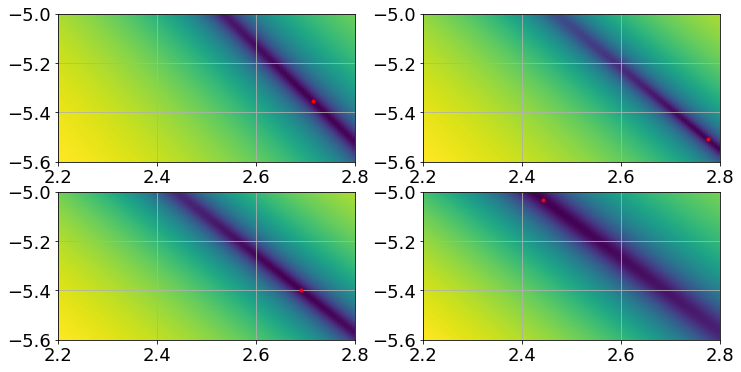

In [325]:
# In this cell we'll search a grid for the best-fit values of a and b.

# Define some functions for exploring paramter space.
def trans_dev(a,b,nlayers,data,nus):
    '''  calculate a chisquare between a model and data(nu).  
    '''
    alphaz = a*nlayers*(nus/30)**b
    T = np.exp(-alphaz)
    sumdev = np.sum((T-data)**2)
    return sumdev

def fitgoodness(nlayers,data,nus):
    '''  Over a broad grid in parameters (a,b), calculate the chisq and return an array.
         We're doing this rather than a fancy minimization because we want to see the 
         structure and compare results for different layers.
    '''
    aii = 0
    for a in avec:
        bii = 0
        for b in bvec:
            resultarr[bii,aii]=trans_dev(a,b,nlayers,data,nus)
            bii += 1
        aii += 1
    return resultarr

def minlocation(avec,bvec,resultarr):
    ''' Find the values of parameters (a,b) at the chisq minimum.
    '''
    a_ii = np.where(resultarr==np.min(resultarr))[1][0]
    a_value = avec[a_ii]
    b_ii = np.where(resultarr==np.min(resultarr))[0][0]
    b_value = bvec[b_ii]
    return a_value,b_value


# Set the ranges of (a,b) for our grid.
bmin = 2.2
bmax = 2.8
amin = -5.6
amax = -5
bvec = np.linspace(bmin,bmax,100)
avec = np.logspace(amin,amax,200)
resultarr = np.zeros((len(bvec),len(avec)))

# We'll do 4 subplots, for the 4 data sets.
fig,axs = plt.subplots(2,2)
aspects=.5  # This sets the aspect ratio of each subplot.

# 1 layer data
data = rtmli_1
nus = nu1
nlayers=1
resultarr=fitgoodness(nlayers,data,nus)
aval,bval = minlocation(avec,bvec,resultarr)
print('1 Layer: a = {0:4.2e}, b={1:3.2f}'.format(aval,bval))
#axs[0,0].contour(np.log(resultarr),origin='lower',extent=[amin,amax,bmin,bmax])
axs[0,0].imshow(np.log(resultarr).T,origin='lower',extent=[bmin,bmax,amin,amax])
axs[0,0].plot(bval,np.log10(aval),'.r')
axs[0,0].set_aspect(aspects)
axs[0,0].grid()

# 6 layer data
data = rtmli_2
nus = nu2
nlayers=6
resultarr=fitgoodness(nlayers,data,nus)
aval,bval = minlocation(avec,bvec,resultarr)
print('6 Layers: a = {0:4.2e}, b={1:3.2f}'.format(aval,bval))
#axs[0,0].contour(np.log(resultarr),origin='lower',extent=[amin,amax,bmin,bmax])
axs[0,1].imshow(np.log(resultarr).T,origin='lower',extent=[bmin,bmax,amin,amax])
axs[0,1].plot(bval,np.log10(aval),'.r')
axs[0,1].set_aspect(aspects)
axs[0,1].grid()

# 12 layer data
data = rtmli_3
nus = nu3
nlayers=12
resultarr=fitgoodness(nlayers,data,nus)
aval,bval = minlocation(avec,bvec,resultarr)
print('12 Layers: a = {0:4.2e}, b={1:3.2f}'.format(aval,bval))
#axs[0,0].contour(np.log(resultarr),origin='lower',extent=[amin,amax,bmin,bmax])
axs[1,0].imshow(np.log(resultarr).T,origin='lower',extent=[bmin,bmax,amin,amax])
axs[1,0].plot(bval,np.log10(aval),'.r')
axs[1,0].set_aspect(aspects)
axs[1,0].grid()

# 24 layer data
data = rtmli_4
nus = nu4
nlayers=24
resultarr=fitgoodness(nlayers,data,nus)
aval,bval = minlocation(avec,bvec,resultarr)
print('24 Layers: a = {0:4.2e}, b={1:3.2f}'.format(aval,bval))
#axs[1,1].contour(np.log(resultarr).T,origin='lower',extent=[bmin,bmax,amin,amax])
axs[1,1].imshow(np.log(resultarr).T,origin='lower',extent=[bmin,bmax,amin,amax])
axs[1,1].plot(bval,np.log10(aval),'.r')
axs[1,1].set_aspect(aspects)
axs[1,1].grid()


We see remarkable consistency in the best-fit values of a and b here.   The 24-layer one appears to be an outlier.
For simplicity, we're going to adopt the values for the 12-layer fit, and see what happens if we use those for all four data sets.  Now let's plot the data (for each value of N_layers) vs the model. 

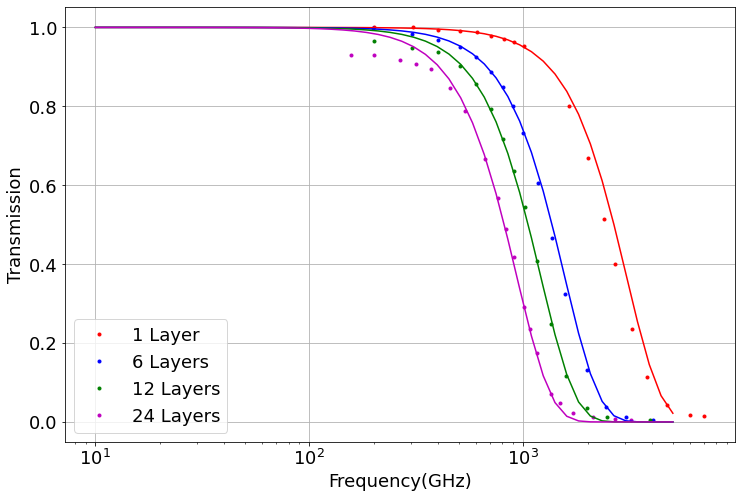

In [327]:
%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 8]

nu_ghz = np.logspace(1,3.7,50)
a = 4.00e-6
b = 2.69

# 1 layer
nlayers=1

ptype = ['.r','.b','.g','.m']
plt.semilogx(nu1,rtmli_1,ptype[0],label='1 Layer')
plt.semilogx(nu2,rtmli_2,ptype[1],label='6 Layers')
plt.semilogx(nu3,rtmli_3,ptype[2],label='12 Layers')
plt.semilogx(nu4,rtmli_4,ptype[3],label='24 Layers')
plt.legend()

ltype = ['r','b','g','m']
ii = 0
for nlayers in [1,6,12,24]:
    alphaz = a*nlayers*(nu_ghz/30)**b
    T = np.exp(-alphaz)
    plt.semilogx(nu_ghz,T,ltype[ii])
    ii = ii+1

plt.xlabel('Frequency(GHz)')
plt.ylabel('Transmission')
plt.grid()


These look pretty good, but it's clear the model doesn't match the data very well for the 12 or 24 layer curves at low frequencies. We'll proceed using b = 2.69, rounded to 2.7 , which is close to the values for the 1,6 and 12 layer fits.   

Now we'll now go and recalculate "a" from Bicep3's loading.  Table 2 in https://arxiv.org/pdf/1808.00567.pdf 
(Kange etal, "2017 upgrade and performance of BICEP3: a 95GHz
refracting telescope for degree-scale CMB polarization") says the RTMLI foam filter stack has an RJ temperature of 0.79K.   

Ignoring the very small transmission loss in each layer, 
the RJ loading is 

$$ T_{RJ} = \sum \epsilon T_i = N \epsilon \frac{\sum T_i}{N} = N \epsilon T_{avg} ,$$

where $\epsilon$ is the emissivity (== absorption) in a single layer.

The stack is located between the ambient (say 250K) foam window and the 50K alumina filter.  Let's say the top is at 220K, the bottom at 60K, giving $T_{avg} = 140$K.  Using this, and the number of layers and loading from Bicep3, we can estimate the absorption in each layer.



Bicep3, 90GHz, 1 layer abs = 5.64e-04
              10 layer abs = 5.64e-03
Bicep3 => alpha_1layer(90GHz) = 5.644e-04
Bicep3 =>                   a = 2.907e-05


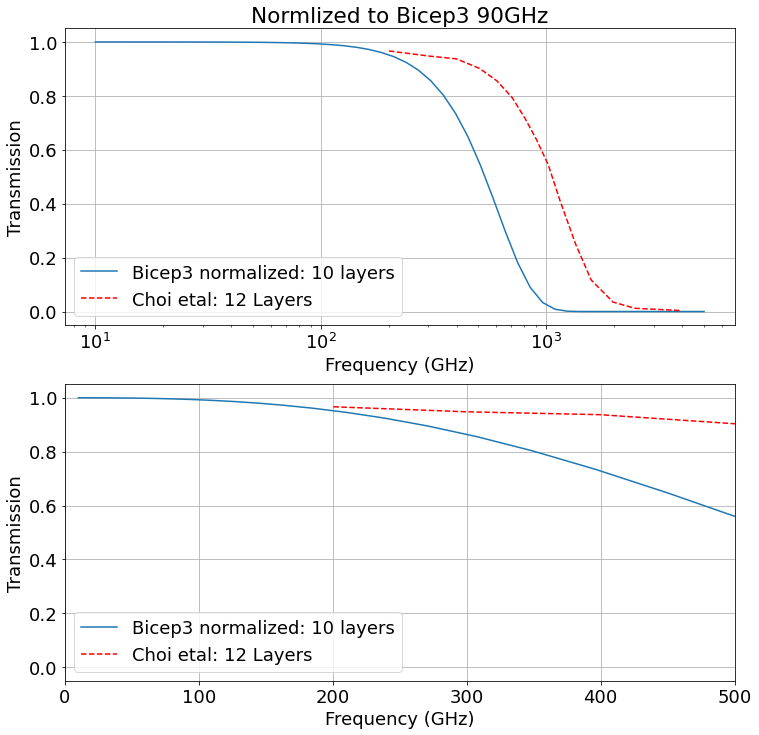

In [332]:
#  Bicep 3, at 90GHz
Trj = 0.79 #K
Nlayers = 10
Tavg = 140 #K

b=2.7 # from above.

abs_1layer = Trj/(Nlayers*Tavg)
trans_1layer = 1-abs_1layer
print('Bicep3, 90GHz, 1 layer abs = {0:4.2e}'.format(abs_1layer))
print('              10 layer abs = {0:4.2e}'.format(abs_1layer*10))


# Find Halpern model's "a"
# trans_1layer = np.exp(-alpha_1layer)
alpha_1layer = -np.log(trans_1layer)  # at 90GHz

# alpha = a*(nu/30)**b
a = alpha_1layer / ((90/30)**b )

print('Bicep3 => alpha_1layer(90GHz) = {0:4.3e}'.format(alpha_1layer))
print('Bicep3 =>                   a = {0:4.3e}'.format(a))

# Using "a"
# alpha = a*(nu_ghz/30)**b
alphaN = Nlayers*a*(nu_ghz/30)**b
abs_Nlayers = np.exp(-alphaN)
T_Nlayers = 1 - abs_Nlayers

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

plt.subplot(2,1,1)
plt.semilogx(nu_ghz,abs_Nlayers,label='Bicep3 normalized: 10 layers')
plt.semilogx(nu3,rtmli_3,'--r',label='Choi etal: 12 Layers')
plt.title('Normlized to Bicep3 90GHz')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Transmission')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(nu_ghz,abs_Nlayers,label='Bicep3 normalized: 10 layers')
plt.plot(nu3,rtmli_3,'--r',label='Choi etal: 12 Layers')
plt.xlim(0,500)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Transmission')
plt.legend()
plt.grid()

### A discrepancy

Looking at curves above, we see that our model of the Zotefoam is clearly, per layer, much more absorbing than the foam in the original RTMLI paper.  
This is a bit disturbing, since we've long believed that Zotefoam is one of the most transparent foams available at 90 and 150GHz.  Clearly we need more data.

Let's look at another data set that I received informally from a Spider colleague, measurements done by Lorenzo Moncelsi at Caltech on HD30, which is the foam we're actually interested in.  Once again I digitized some points approximating the measured curve in a plot, using a web tool.  This sample is 125mm thick, or about 42 of the 3mm layers.

(0.8, 1.0)

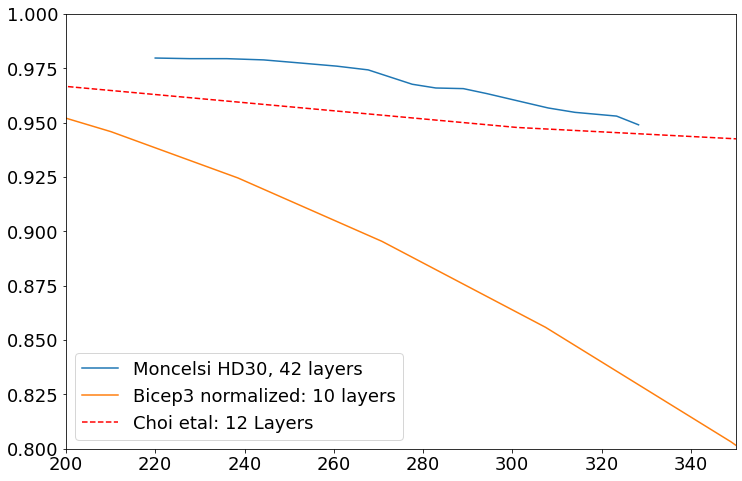

In [337]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 8]

nu5,trans_HD30 = np.loadtxt('Moncelsi_HD30_nonlaminated_trans_vs_nu.txt',unpack=True,delimiter=', ')


plt.clf()
plt.plot(nu5,trans_HD30,label='Moncelsi HD30, 42 layers')
plt.plot(nu_ghz,abs_Nlayers,label='Bicep3 normalized: 10 layers')
plt.plot(nu3,rtmli_3,'--r',label='Choi etal: 12 Layers')
plt.legend()
plt.xlim(200,350)
plt.ylim(0.8,1)

From these curves we see that the Bicep3 loading normalization is very suspect.  Lorenzo's measurements show HD30 being better than the foam used in Choi etal, which is what we expected.

Let's now go and fit Lorenzo's data to a Halpern-like model, finding the best-fit (a,b).

1 Layer: a = 1.45e-06, b=2.82


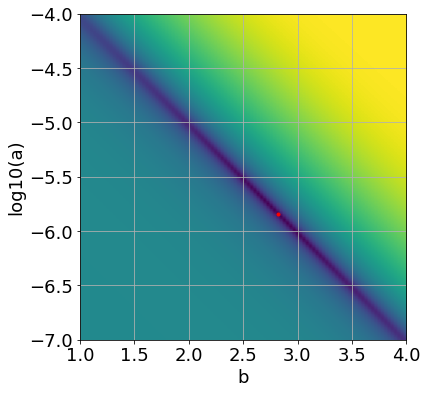

In [338]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 6]

# Set the ranges of (a,b) for our grid.
bmin = 1
bmax = 4
amin = -7
amax = -4       
bvec = np.linspace(bmin,bmax,100)
avec = np.logspace(amin,amax,200)
resultarr = np.zeros((len(bvec),len(avec)))

data = trans_HD30
nus = nu5
nlayers=42
resultarr=fitgoodness(nlayers,data,nus)
aval,bval = minlocation(avec,bvec,resultarr)
print('1 Layer: a = {0:4.2e}, b={1:3.2f}'.format(aval,bval))
#axs[0,0].contour(np.log(resultarr),origin='lower',extent=[amin,amax,bmin,bmax])
plt.imshow(np.log(resultarr).T,origin='lower',extent=[bmin,bmax,amin,amax])
plt.plot(bval,np.log10(aval),'.r')
plt.xlabel('b')
plt.ylabel('log10(a)')
plt.grid()

We note that the best fit value of $b$ is very close to that we found from the Choi etal data!   But, the normalization factor, $a$, is more than a factor of 10 lower than we derived from the Bicep3 loading.

Let's now plot our best-fit model on top of Lorenzo's data.

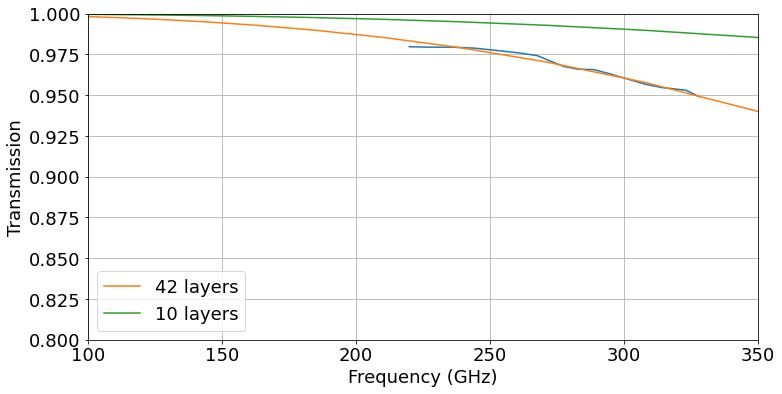

In [342]:
plt.clf()
plt.plot(nu5,trans_HD30)
plt.plot(nu_ghz,np.exp(-aval*nlayers*(nu_ghz/30)**bval), label = '42 layers')
plt.plot(nu_ghz,np.exp(-aval*10*(nu_ghz/30)**bval), label = '10 layers')
plt.legend()
plt.xlim(100,350)
plt.ylim(0.8,1)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Transmission')
plt.grid()

## RTMLI summary

Based on the agreement between the Choi etal data and Lorenzo's data for HD30 for $b$, and because Lorenzo's transmission measurements are a more direct probe of what we're looking for than the Bicep3 in-band loading estimate, we will adopt the best fit $a$ and $b$ found from the fit to Lorenzo's data, for CMB-S4's model of RTMLI.  As we can see above, 10 layers of HD30 have very little loss out to 300GHz. 